In [1]:
# Import libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# For reproducibility
np.random.seed(42)

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from keras.preprocessing.image import ImageDataGenerator 
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%config InlineBackend.figure_format = 'retina'
from keras.models import load_model
import keras
import h5py
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img

C:\Users\Vera\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Vera\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Vera\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Vera\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (

In [2]:
# csv vile containg the image number and the style that goes with it.
df = pd.read_csv("./binary_names_style.csv")

# ImageDataGenerator does the preprocessing, image agumentation and split
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             channel_shift_range=100,
                             brightness_range=(0.2, 1.5), #originally 0.75, 1.25
                             validation_split=0.25) #and i split my data here into training and testing

# per keras documentation validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).
# I assume that the validation set will not be agumented.

train_gen = datagen.flow_from_dataframe(
        dataframe=df, #the dataframe i read in
        directory='./images2', #folder containing images
        x_col="new_filename", #column in the file that is the image name
        y_col="style", #the style that goes with the image, which is what I want to predict
        target_size=(256, 256),
        batch_size=32,
        subset='training',
        color_mode='rgb',
        class_mode='binary') # class_mode='categorical' #try with color mode brayscale

val_gen = datagen.flow_from_dataframe(
        dataframe=df, #the dataframe i read in
        directory='./images2', #folder containing images
        x_col="new_filename", #column in the file that is the image name
        y_col="style", #the style that goes with the image, which is what I want to predict
        target_size=(256, 256),
        batch_size=32,
        subset='validation',
        color_mode='rgb',
        class_mode='binary') # class_mode='categorical'

Found 14946 validated image filenames belonging to 2 classes.
Found 4982 validated image filenames belonging to 2 classes.


### Creating the model

- CNN's go through two phases, a convolutional phase and then a fully connected/dense phase.
- My convolution phase will have 4 stages
- each activation function in this phase will be relu,
- Each kernel size will be 3x3 which will also be the kernel size in the MaxPooling layer.
- Included padding in each layer because I feel that the edges of each image are important.

In [18]:
# Instantiate a CNN.
model = Sequential()

# 1st convolutional layer.
model.add(Conv2D(filters = 32, #from 64 to 32
                       kernel_size = (3,3),
                       activation = 'relu',
                       padding='same',
                       input_shape = (256,256,3))) # first input shape is the same that is in the target size w/ 3 for the rbg channels

# 1st pooling layer.
model.add(MaxPooling2D(pool_size = (3,3))) # dimensions of region of pooling

# 2nd convolutional layer
model.add(Conv2D(64, #from 128/ to 64
                       kernel_size = (3,3),
                       padding='same',
                       activation = 'relu'))

# 2nd pooling layer.
model.add(MaxPooling2D(pool_size = (3,3)))

# 3rd convolutional layer
model.add(Conv2D(128, #from 256 to 128
                       kernel_size = (3,3),
                       padding='same',
                       activation = 'relu'))

# 3rd pooling layer.
model.add(MaxPooling2D(pool_size = (3,3)))

# 4th convolutional layer
model.add(Conv2D(256, #from 512 to 256
                       kernel_size = (3,3),
                       padding='same',
                       activation = 'relu'))

# 4th pooling layer.
model.add(MaxPooling2D(pool_size = (3,3)))

# 5th convolutional layer
# model.add(Conv2D(512,
#                        kernel_size = (3,3),
#                        padding='same',
#                        activation = 'relu'))

# 4th pooling layer.
#model.add(MaxPooling2D(pool_size = (3,3)))


# Flattening before moving to the fully connected phase.
model.add(Flatten())

### Second phase of CNN
- It is done after the flattening. This moves toa  dense/fully connected phase, where the final neurons will be the number of categories (3).
- Using softmax activation in the final dense layer because it is a multi classification problem.
- Including a 0.5 dropout between each dense layer to avoid over fitting.
- Metric is accuracy because I want to mesaure how accuratly my model will predict

In [28]:
# note to self do not run last pooling layer

In [19]:

# 1st densely-connected layer
model.add(Dense(256, activation = 'relu')) # from 512 to 256
#model.add(Dropout(0.2)) #from 0.5 dropout to 0.2

# 2nd densely-connected layer
model.add(Dense(128, activation = 'sigmoid')) # from 256 to 128
#model.add(Dropout(0.2)) #from 0.5 dropout to 0.2

# 3rd densely-connected layer
#model.add(Dense(64, activation = 'relu')
#model.add(Dropout(0.2)) #from 0.5 dropout to 0.2

# Final dense layer w/ 3 neurons for the 3 categories.
model.add(Dense(1, activation = 'sigmoid'))

# Compile model
model.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics=['acc'])

# Fit model on training data
# history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=20,
#                               validation_data=validation_generator,validation_steps=validation_steps)

### Fitting the model

In [20]:
history = model.fit_generator(train_gen,
                          validation_data = val_gen,
                          epochs = 20,
                          verbose = 1)

Epoch 1/20
468/468 [==============================] - 4321s 9s/step - loss: 0.6771 - acc: 0.5719 - val_loss: 0.6292 - val_acc: 0.6530
Epoch 2/20
468/468 [==============================] - 3617s 8s/step - loss: 0.6245 - acc: 0.6551 - val_loss: 0.6078 - val_acc: 0.6612
Epoch 3/20
468/468 [==============================] - 3142s 7s/step - loss: 0.5905 - acc: 0.6872 - val_loss: 0.5576 - val_acc: 0.7200
Epoch 4/20
468/468 [==============================] - 3719s 8s/step - loss: 0.5640 - acc: 0.7090 - val_loss: 0.5479 - val_acc: 0.7184
Epoch 5/20
468/468 [==============================] - 6336s 14s/step - loss: 0.5510 - acc: 0.7201 - val_loss: 0.5422 - val_acc: 0.7270
Epoch 6/20
468/468 [==============================] - 2756s 6s/step - loss: 0.5342 - acc: 0.7318 - val_loss: 0.5159 - val_acc: 0.7465
Epoch 7/20
468/468 [==============================] - 2757s 6s/step - loss: 0.5271 - acc: 0.7407 - val_loss: 0.5486 - val_acc: 0.7260
Epoch 8/20
468/468 [==============================] - 2717s 6

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 256)         295168    
__________

In [37]:
preds = model.predict_generator(val_gen,
                      verbose=1)

156/156 [==============================] - ETA: 20:4 - ETA: 18:2 - ETA: 17:3 - ETA: 17:0 - ETA: 15:4 - ETA: 15:5 - ETA: 15:3 - ETA: 15:4 - ETA: 15:4 - ETA: 15:4 - ETA: 15:5 - ETA: 15:5 - ETA: 15:4 - ETA: 15:3 - ETA: 15:2 - ETA: 15:0 - ETA: 14:4 - ETA: 14:5 - ETA: 14:4 - ETA: 14:3 - ETA: 14:1 - ETA: 14:0 - ETA: 14:0 - ETA: 13:5 - ETA: 13:5 - ETA: 15:1 - ETA: 15:1 - ETA: 15:0 - ETA: 14:5 - ETA: 14:4 - ETA: 14:4 - ETA: 14:3 - ETA: 14:2 - ETA: 14:2 - ETA: 14:2 - ETA: 14:0 - ETA: 13:5 - ETA: 13:4 - ETA: 13:4 - ETA: 13:3 - ETA: 13:2 - ETA: 13:1 - ETA: 13:0 - ETA: 13:0 - ETA: 12:4 - ETA: 12:3 - ETA: 12:3 - ETA: 12:2 - ETA: 12:1 - ETA: 12:0 - ETA: 11:5 - ETA: 11:4 - ETA: 11:3 - ETA: 11:2 - ETA: 11:3 - ETA: 11:3 - ETA: 12:2 - ETA: 12:0 - ETA: 11:5 - ETA: 11:4 - ETA: 11:3 - ETA: 11:2 - ETA: 11:2 - ETA: 11:1 - ETA: 11:0 - ETA: 10:5 - ETA: 10:4 - ETA: 10:3 - ETA: 10:2 - ETA: 10:2 - ETA: 10:0 - ETA: 10:0 - ETA: 9:5 - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 9: - ETA: 8: - ETA: 8: - ETA: 8: - ET

In [38]:
preds

array([[0.2513621 ],
       [0.56623614],
       [0.28259116],
       ...,
       [0.06382871],
       [0.38502318],
       [0.31212708]], dtype=float32)

In [41]:
predicted_classes = np.where(preds>0.5, 1, 0)

In [42]:
print('Confusion Matrix')
cm = metrics.confusion_matrix(val_gen.classes, predicted_classes)
print(cm)

Confusion Matrix
[[1884  976]
 [1383  739]]


In [ ]:
# so in my confusion matrix the top right is true negatives, top left is false positives
# btoom left is false negatives bottom right is true positives
# curtosy of https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model

In [43]:
print('Classification Report')
print(metrics.classification_report(val_gen.classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.66      0.61      2860
           1       0.43      0.35      0.39      2122

    accuracy                           0.53      4982
   macro avg       0.50      0.50      0.50      4982
weighted avg       0.51      0.53      0.52      4982



In [44]:
model.save_weights('model_weights.h5')

In [45]:
model.save('model_keras.h5') # saved my mdoel!

In [5]:
# from keras.utils import plot_model
# plot_model(loaded_model, to_file='model.jpg')
# pip installed pydot but need to re run the model i believe

In [3]:
import tensorflow as tf 
loaded_model = tf.keras.models.load_model('./model_keras.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [4]:
print(loaded_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 256)         295168    
__________

In [6]:
preds = loaded_model.predict_generator(val_gen,
                      verbose=1)

156/156 [==============================] - 931s 6s/step


In [7]:
preds

array([[0.39944258],
       [0.15056804],
       [0.09813249],
       ...,
       [0.20486543],
       [0.34118947],
       [0.9028821 ]], dtype=float32)

In [8]:
predicted_classes2 = np.where(preds>0.5, 1, 0)

In [9]:
print('Confusion Matrix')
cm2 = metrics.confusion_matrix(val_gen.classes, predicted_classes2)
print(cm2)

Confusion Matrix
[[1896  964]
 [1383  739]]


In [6]:
# from keras.utils import plot_model
# plot_model(loaded_model, to_file='model.png')

In [11]:
history = loaded_model.fit_generator(train_gen,
                          validation_data = val_gen,
                          epochs = 3,
                          verbose = 1)

Epoch 1/3
468/468 [==============================] - 3437s 7s/step - loss: 0.4481 - acc: 0.7902 - val_loss: 0.4468 - val_acc: 0.7933
Epoch 2/3
468/468 [==============================] - 2781s 6s/step - loss: 0.4463 - acc: 0.7886 - val_loss: 0.4471 - val_acc: 0.7945
Epoch 3/3
468/468 [==============================] - 2880s 6s/step - loss: 0.4429 - acc: 0.7886 - val_loss: 0.4457 - val_acc: 0.7888


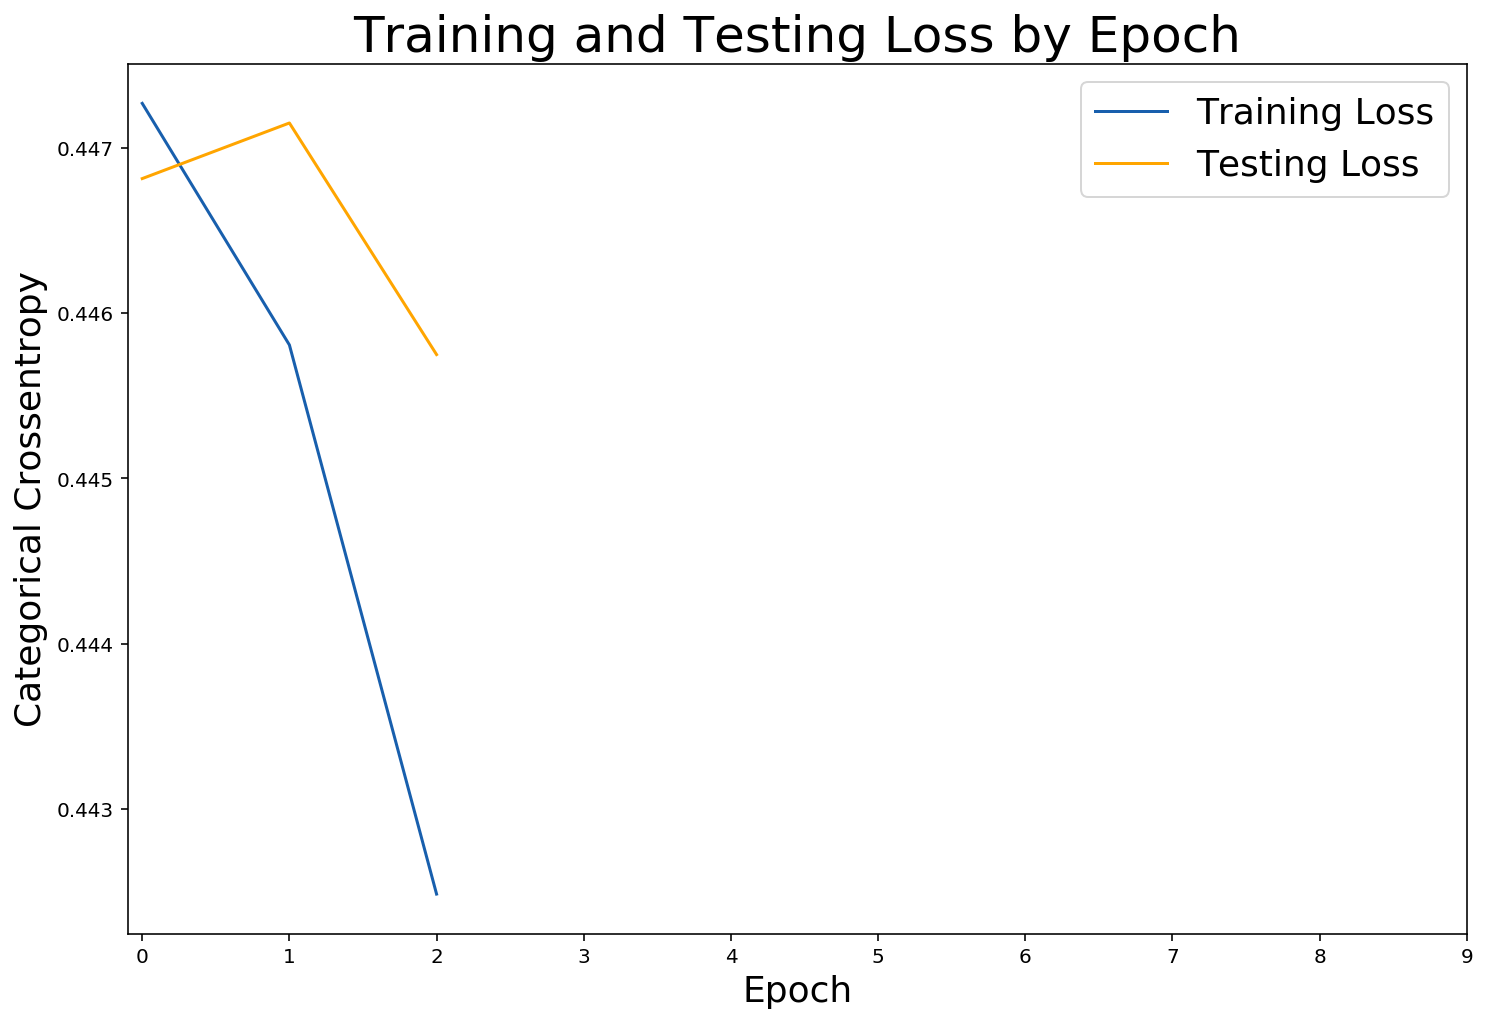

In [12]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);

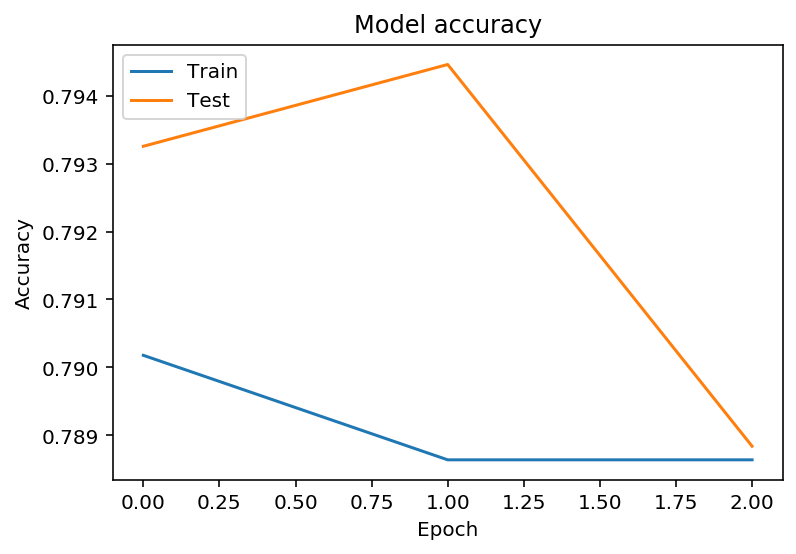

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

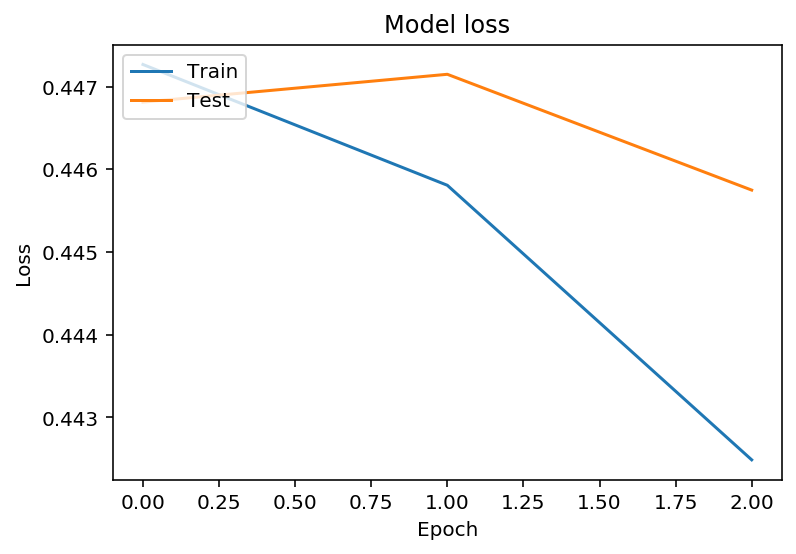

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
#creating predictions

In [22]:
preds = loaded_model.predict_generator(val_gen,
                      verbose=1)

156/156 [==============================] - 869s 6s/step


In [23]:
predict = loaded_model.predict(val_gen,
                      verbose=1)

156/156 [==============================] - 764s 5s/step


In [25]:
predicted_classes2 = np.where(preds>0.5, 1, 0)

In [26]:
print('Confusion Matrix')
cm2 = metrics.confusion_matrix(val_gen.classes, predicted_classes2)
print(cm2)

Confusion Matrix
[[1866  994]
 [1355  767]]


In [28]:
df = pd.DataFrame(preds, columns=['Percentages'])
df['filename'] = val_gen.filenames
df['true classes'] = val_gen.classes
df['predicted classes'] = predicted_classes2

In [29]:
df.head()

,Percentages,filename,true classes,predicted classes
0,0.125125,84512.jpg,1,0
1,0.223655,99442.jpg,1,0
2,0.438450,75956.jpg,1,0
3,0.166306,7486.jpg,1,0
4,0.482881,35766.jpg,1,0


In [44]:
df.sort_values('Percentages', axis=0, ascending=False).tail(20)

,Percentages,filename,true classes,predicted classes
4350,0.014308,12906.jpg,1,0
2676,0.014256,12985.jpg,0,0
4403,0.014180,67478.jpg,1,0
4558,0.014177,66244.jpg,1,0
2195,0.014168,57702.jpg,1,0
4097,0.014138,60198.jpg,0,0
4092,0.014137,27315.jpg,0,0
2300,0.014134,53885.jpg,1,0
4668,0.014118,84513.jpg,0,0
346,0.014107,3266.jpg,0,0


In [33]:
#using .loc to identify if famous works for art from the time periods were in the validation and if they were correctly
# or incorrectly predicted

In [32]:
df.loc[df['filename'] == '81823.jpg']
# Impressionism
# Renoir - Dance at Moulin de la Galette

,Percentages,filename,true classes,predicted classes
1139,0.69235,81823.jpg,0,1


In [34]:
df.loc[df['filename'] == '54404.jpg']
# Impressionism
# Renoir - The luncheon of the Boating Party

,Percentages,filename,true classes,predicted classes
2691,0.95847,54404.jpg,0,1


In [35]:
df.loc[df['filename'] == '287.jpg']
# Impressionism
# Monet - Water lilies (he has over 250 works of this name)

,Percentages,filename,true classes,predicted classes
1149,0.958642,287.jpg,0,1


In [36]:
df.loc[df['filename'] == '8396.jpg']
# Monet - Impression, sunrise

,Percentages,filename,true classes,predicted classes
1244,0.596689,8396.jpg,0,1


In [37]:
df.loc[df['filename'] == '70336.jpg']
# Romanticism
# Goya - Saturn Devouring His Son

,Percentages,filename,true classes,predicted classes
630,0.889462,70336.jpg,1,1


In [38]:
df.loc[df['filename'] == '21957.jpg']
# Romanticism
# Goya - The Third of May 1818

,Percentages,filename,true classes,predicted classes
317,0.924077,21957.jpg,1,1


In [39]:
df.loc[df['filename'] == '56906.jpg']
# Romanticism
# William Turner - The Fighting Temeraire...

,Percentages,filename,true classes,predicted classes
6,0.1496,56906.jpg,1,0


In [40]:
df.loc[df['filename'] == '62893.jpg']
# Romanticism
# William Turner - The Fighting Temeraire...

,Percentages,filename,true classes,predicted classes
149,0.356501,62893.jpg,1,0


In [41]:
df.loc[df['filename'] == '58844.jpg']
# Romanticism
# Delacroix - 28 July: The Liberty Leading the People

,Percentages,filename,true classes,predicted classes
3911,0.984418,58844.jpg,1,1


In [42]:
df.loc[df['filename'] == '90455.jpg']
# Romanticism
# Delacroix - Death of Sardanapalus

,Percentages,filename,true classes,predicted classes
2162,0.374991,90455.jpg,1,0


In [43]:
df.loc[df['filename'] == '43181.jpg'] # not in validation set
# Romanticism
# Delacroix - Death of Sardanapalus - Sketch

,Percentages,filename,true classes,predicted classes


In [20]:
# tf.keras.utils.plot_model(
#     loaded_model, to_file='model.png', show_layer_names=True,
#     rankdir='TB')

In [21]:
# from IPython.display import SVG
# from keras.utils import model_to_dot

# SVG(model_to_dot(loaded_model).create(prog='dot', format='svg'))

In [13]:
#loaded_model = keras.models.load_model('./model_keras.h5')

In [ ]:
# from keras.utils.vis_utils import plot_model
# import pydot
# plot(model, show_shapes=True, to_file='model.png')
# save as dot file and go to website to graph it, web graph vix, copy text and it will generate graph